In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - marginalize_linear_model.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Perform the linear algebra to marginalize the linear model of Hogg+ 2010 with a cosine term
'''

__author__ = "James Lane"

In [2]:
# General
import numpy as np
from scipy import linalg
import scipy as sc
from astropy.table import Table
import pdb, sys

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Information
- paper: https://arxiv.org/abs/1008.4686

# About

We assume that the velocity fluctuations induced by the triaxial halo obeys the following restrictions:
- Only produces power in an m=2 mode
- Phase is constant with radius
- Smooth radial trend in power that tends to increase

Fit a simple linear model:

$
v_{T}(R,\phi) = v_{T,0}(R) + A_{T}(R) \cos \big[ 2( \phi - \phi_{b} ) \big] + N_{T}(R)
$

$
v_{R}(R,\phi) =  A_{R}(R) \sin \big[ 2( \phi - \phi_{b} ) \big] + N_{R}(R)
$

- Determine a fixed $\phi_{b}$
- Calculate $m=2$ amplitudes as a function radius
- Compare $m=2$ amplitudes with models

# Prepare

## Functions

In [64]:
def calculate_data_likelihood(gc_R, gc_phi, gc_v, R_bin_cent, R_bin_size, n_bs=10, force_yint_zero=False,
                              trig_function=np.cos):
    '''calculate_data_likelihood:
    
    Calculate the likelihood given the linear model
    
    Args:
        Many
    
    Returns:
        Likelihood (float array) - Likelihood
    
    '''
    
    # Find all the points within this radial bin
    stars_in_R_bin = np.where( ( gc_R < R_bin_cent + R_bin_size/2 ) & 
                               ( gc_R > R_bin_cent - R_bin_size/2 ) )[0]
    n_stars_in_R_bin = len(stars_in_R_bin)
    gc_R_in_R_bin = gc_R[stars_in_R_bin]
    gc_phi_in_R_bin = gc_phi[stars_in_R_bin]
    gc_v_in_R_bin = gc_v[stars_in_R_bin]

    phi_bin_v = np.array([])
    phi_bin_v_err = np.array([])
    phi_bin_phi = np.array([])
    phi_bin_phi_err = np.array([])

    for j in range(n_phi_bins):

        # Find all the points within this phi bin
        stars_in_phi_bin = np.where( ( gc_phi_in_R_bin < phi_bin_cents[j] + phi_bin_size/2 ) &
                                     ( gc_phi_in_R_bin > phi_bin_cents[j] - phi_bin_size/2 ) )[0]
        n_stars_in_phi_bin = len(stars_in_phi_bin)
        gc_R_in_phi_bin = gc_R_in_R_bin[stars_in_phi_bin]
        gc_phi_in_phi_bin = gc_phi_in_R_bin[stars_in_phi_bin]
        gc_v_in_phi_bin = gc_v_in_R_bin[stars_in_phi_bin]

        # If we have more than a certain number of stars then BS
        bs_v_avg_samps = np.array([])
        bs_phi_avg_samps = np.array([])
        if n_stars_in_phi_bin > 10:

            # Loop over BS samples
            for k in range(n_bs):
                sample = np.random.randint(0,n_stars_in_phi_bin,n_stars_in_phi_bin)
                bs_v_avg_samps = np.append( bs_v_avg_samps, np.average(gc_v_in_phi_bin[sample]) )
                bs_phi_avg_samps = np.append( bs_phi_avg_samps, np.average(gc_phi_in_phi_bin[sample]) )
            ###k

            phi_bin_v = np.append( phi_bin_v, np.mean( bs_v_avg_samps ) )
            phi_bin_v_err = np.append( phi_bin_v, np.std( bs_v_avg_samps ) )
            phi_bin_phi = np.append( phi_bin_phi, np.mean( bs_phi_avg_samps ) )
            phi_bin_phi_err = np.append( phi_bin_phi_err, np.std( bs_phi_avg_samps ) )
        ##fi
    ###j

    # Now make the vectors
    n_good_phi_bins = len(phi_bin_v)
    Y = np.zeros((n_good_phi_bins,1))
    C = np.zeros((n_good_phi_bins,n_good_phi_bins))

    Y[:,0] = phi_bin_v
    for j in range(n_good_phi_bins):
        C[j,j] = phi_bin_v_err[j]**2
    ###j
    C_inv = np.linalg.inv(C)


    # Now loop over all possible values of phi B, making the vector 
    # A for each and calculating the likelihood.
    likelihood = np.zeros( n_phib_bins )
    for j in range(n_phib_bins):
        
        if force_yint_zero:
            A = np.ones((n_good_phi_bins,1))
            A[:,0] = trig_function( 2*( phi_bin_phi - phib_bin_cents[j] ) )
        else:
            A = np.ones((n_good_phi_bins,2))
            A[:,1] = trig_function( 2*( phi_bin_phi - phib_bin_cents[j] ) )
        ##ie

        # Now compute the vectors which form the solution
        V_inv = np.linalg.multi_dot( [ A.T, C_inv, A ] )
        V = np.linalg.inv( V_inv )
        W = np.matmul( np.linalg.inv( np.linalg.multi_dot( [A.T,C_inv,A] ) ), np.linalg.multi_dot( [A.T,C_inv,Y] ) )
        U = np.linalg.multi_dot( [Y.T,C_inv,Y-np.matmul(A,W)] )

        likelihood[j] = np.sqrt( np.linalg.det(V)/np.linalg.det(C) ) * np.exp( -U/2 )

    ###j

    # Normalize to 1
    likelihood /= np.sum(likelihood)

    return likelihood
#def

def radial_velocity(R_bin_cents, R_bin_size, phi_range, phi_bin_size, gc_R, gc_phi, gc_v,
                    likelihood, trig_function, phi_bin_size_in_arc=True
                   ):
    '''radial_velocity:
    
    
    '''
    
    n_R = len(R_bin_cents)
    
    # Declare the figure
    fig = plt.figure( figsize=(15,n_R*3) )
    axs = fig.subplots(nrows=n_R, ncols=3)
    
    # Loop over all radii
    for i in range( n_R ):
        
        # Select the stars in this bin
        stars_in_bin = np.where( (gc_R > (R_bin_cents[i]-R_bin_size/2) ) & 
                                 (gc_R < (R_bin_cents[i]+R_bin_size/2) ) )[0]
        gcR_in_bin = gc_R[stars_in_bin]
        gcv_in_bin = gc_v[stars_in_bin]
        gcphi_in_bin = gc_phi[stars_in_bin]

        if phi_bin_size_in_arc:
            # Bin the Gaia data in arc
            arc_min = phi_range[0]*R_bin_cents[i]
            arc_max = phi_range[1]*R_bin_cents[i]
            phi_bin_cents = np.arange( arc_min, arc_max, phi_bin_size)
            phi_bin_cents += ( ( arc_max - arc_min ) % phi_bin_size )/2
            phi_bin_cents /= R_bin_cents[i]
        else:
            phi_bin_cents = np.arange( phi_range[0], phi_range[1], phi_bin_size )
            phi_bin_cents += ( ( phi_range[1] - phi_range[0] ) % phi_bin_size )/2
        ##ie
        
        # Make the bin edges and bin velocity, R, and number in phi
        phi_bin_edges = np.append( phi_bin_cents-np.diff(phi_bin_cents)[0], 
                                   phi_bin_cents[-1]+np.diff(phi_bin_cents)[0] )
        binned_v, _, _ = binned_statistic(gcphi_in_bin, gcv_in_bin, bins=phi_bin_edges, statistic='mean')
        binned_R, _, _ = binned_statistic(gcphi_in_bin, gcR_in_bin, bins=phi_bin_edges, statistic='mean')        
        
        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_bin_edges)
        binned_n = binned_n.astype('float')
        min_N = 20
        where_low_bin_numbers = np.where(binned_n < min_N)
        binned_v[ where_low_bin_numbers ] = np.nan
        binned_R[ where_low_bin_numbers ] = np.nan
        binned_n[ where_low_bin_numbers ] = np.nan

        # Find where there was data
        where_data = np.where( np.isfinite(binned_v) )
        where_no_data = np.where( np.isnan(binned_v) )
        binned_v[ where_no_data ] = np.nan
        binned_R[ where_no_data ] = np.nan
        binned_n[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        binned_v -= np.nanmean( binned_v[where_data] )
        
        axs[i,0].plot( phi_bin_cents, binned_v, linewidth=0.5, color='Black' )
        axs[i,1].plot( phi_bin_cents, binned_R, linewidth=0.5, color='Black' )
        axs[i,2].plot( phi_bin_cents, binned_n, linewidth=0.5, color='Black' )
        axs[i,0].scatter( phi_bin_cents, binned_v, s=5, color='Black' )
        axs[i,1].scatter( phi_bin_cents, binned_R, s=5, color='Black' )
        axs[i,2].scatter( phi_bin_cents, binned_n, s=5, color='Black' )
        
        axs[i,2].set_yscale("log", nonposy='clip')
        
        axs[i,0].annotate( r'$R_{cen}=$'+str(R_bin_cents[i])+' kpc', xy=(0.05,0.8), xycoords='axes fraction' )
        axs[i,1].set_ylim( R_bin_cents[i]-R_bin_size/2, R_bin_cents[i]+R_bin_size/2 )
        
        axs[i,0].set_xlim( phi_range[0], phi_range[1] )
        axs[i,1].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_xlim( phi_range[0], phi_range[1] )
        axs[i,2].set_ylim( 1, 5000)
        
        # Add a bar
        axs[i,0].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,1].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        axs[i,2].axvline( 25*(np.pi/180), linestyle='dashed', linewidth=0.5, color='Red' )
        
        axs[i,0].axhline( 0.0, linestyle='dashed', linewidth=0.5 )
        axs[i,1].axhline( R_bin_cents[i], linestyle='dashed', linewidth=0.5 )
        axs[i,2].axhline( min_N, linestyle='dashed', linewidth=0.5 )
        
        axs[i,1].set_ylabel(r'$\bar{R}$ [kpc]')
        axs[i,2].set_ylabel(r'$N$')
        
        axs[i,0].set_xlabel(r'$\phi$')
        axs[i,1].set_xlabel(r'$\phi$')
        axs[i,2].set_xlabel(r'$\phi$')
        
        # Estimate the amplitude of the sinusoid
        amp_estimate = np.nanmax( np.abs( binned_v ) )
        
        # Find the maximum likelihood
        max_likelihood_ind = np.argmax( likelihood[i,:] )
        trig_phis = np.linspace(-np.pi/2, np.pi/2, num=100)
        
        # Plot the peak
        phib_lims = [-np.pi/2, np.pi/2]
        phib_bin_size = np.pi/20
        phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
        axs[i,0].plot(trig_phis, amp_estimate*trig_function(2*(trig_phis-phib_bin_cents[max_likelihood_ind]-np.pi/4)))
        axs[i,0].plot(trig_phis, -amp_estimate*trig_function(2*(trig_phis-phib_bin_cents[max_likelihood_ind]-np.pi/4)))

#         # Check if likelihoods are in log
#         if len( np.where( likelihood < 0 )[0] ) > 1:
#             likelihood = np.exp( likelihood )
        
#         # Sample from the likelihood
#         phib_lims = [-np.pi/2, np.pi/2]
#         phib_bin_size = np.pi/20
#         phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
        
#         trig_phis = np.linspace(-np.pi/2, np.pi/2, num=100)
#         n_phib_samps = 0
#         phib_samps = np.zeros(n_phib_samps)
#         phib_samps_good = 0
#         while phib_samps_good < n_phib_samps:
#             # Pick a random phib between -np.pi/2 and np.pi/2
#             rand_phib = np.random.choice( phib_bin_cents, size=1 )[0]
#             rand_ind = np.where( phib_bin_cents == rand_phib )[0]
#             rand_likelihood = np.random.random(1)[0]
#             if rand_likelihood < likelihood[i,rand_ind]:
#                 axs[i,0].plot( trig_phis, amp_estimate * trig_function( 2*( trig_phis - rand_phib ) ), 
#                               linewidth=0.5, alpha=0.2, color='DodgerBlue')
#                 phib_samps_good += 1
#             else: 
#                 continue
#             ##ie
#         ##wh
    ###i

    return fig, axs

#def

def normalize_log_likelihood(x):
    '''normalize_log_likelihood:
    '''
    sum_exp_x =  np.sum(np.exp(x))
    normed_x = np.log( np.exp( x ) / sum_exp_x )
    return normed_x
#def

## Load Data

In [5]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [7]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [8]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy
gc_phi = np.arctan2(gc_y,-gc_x)

## Creating vectors

The solution to the equation with the $\chi^{2}$ term is:

$
\chi^2 = ({\bf X} - {\bf W})^T {\bf V}^{-1}\,({\bf X} - {\bf W}) + {\bf U}
$

with

$
W = [A^{T}C^{-1}A]^{-1}A^{T}C^{-1}Y
$

$
W^{T} = Y^{T}C^{-1}A[A^{T}C^{-1}A]^{-1}
$

$
V^{-1} = A^{T}C^{-1}A
$

and

$
U = Y^{T}C^{-1}[Y-AW]
$

The solution to the integral is:

$
p( \phi_{b} | Data ) \propto \sqrt{ \frac{ \det V }{ \det \Sigma } }\exp[-U/2]
$

First, create $\mathbf{A}$, a $N \times 2$ matric of $1$ and $\cos[2(\phi-\phi_{b})]$. Also create $\mathbf{Y}$, a column vector of velocity data points. Finally, make the covariance matrix after bootstrapping in bins.

# Loop over all radii

In [9]:
R_lims = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2
n_R_bins = len(R_bin_cents)

phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/20
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2
n_phi_bins = len(phi_bin_cents)

phib_lims = [-np.pi/2, np.pi/2]
phib_bin_size = np.pi/20
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2
n_phib_bins = len(phib_bin_cents)

# Tangential Velocity

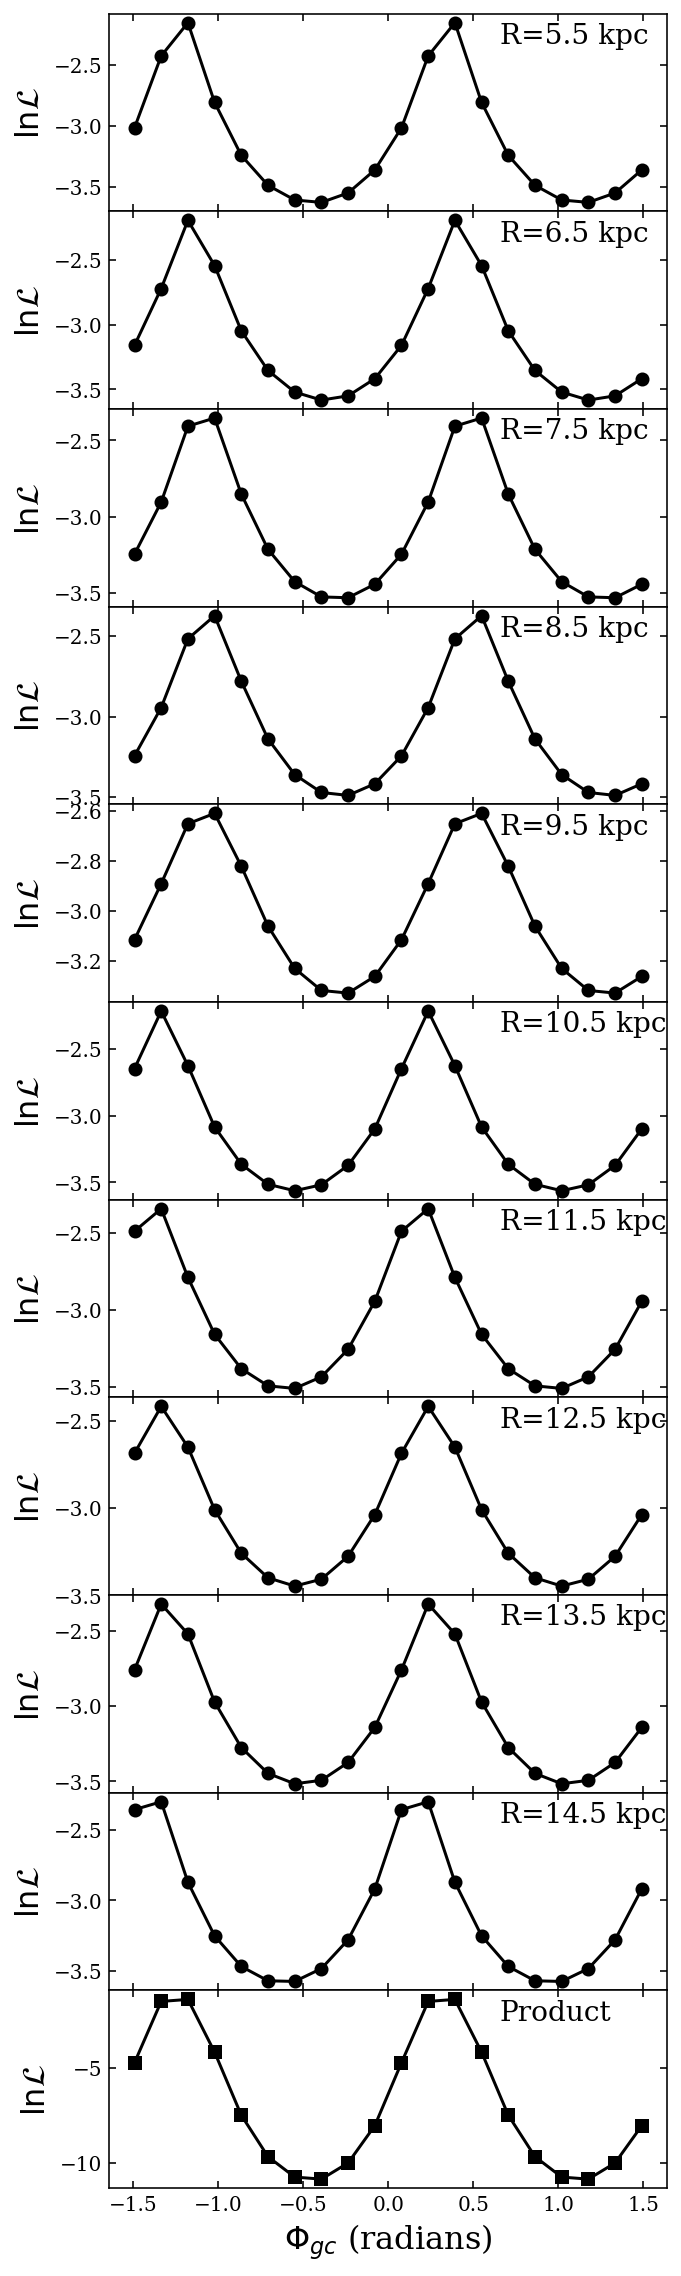

In [44]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vT = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    likelihood = calculate_data_likelihood(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, n_bs=50,
                                           force_yint_zero=False, trig_function=np.cos)
    
    store_likelihood_vT[i,:] = np.log(likelihood)

    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood), marker='o', color='Black' )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].tick_params(labelbottom='off')
    ##fi

prod_likelihood_vT = np.sum(store_likelihood_vT, axis=0)
prod_likelihood_vT = normalize_log_likelihood(prod_likelihood_vT)

axs[-1].plot( phib_bin_cents, prod_likelihood_vT, marker='s', color='Black' )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16) 

axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;

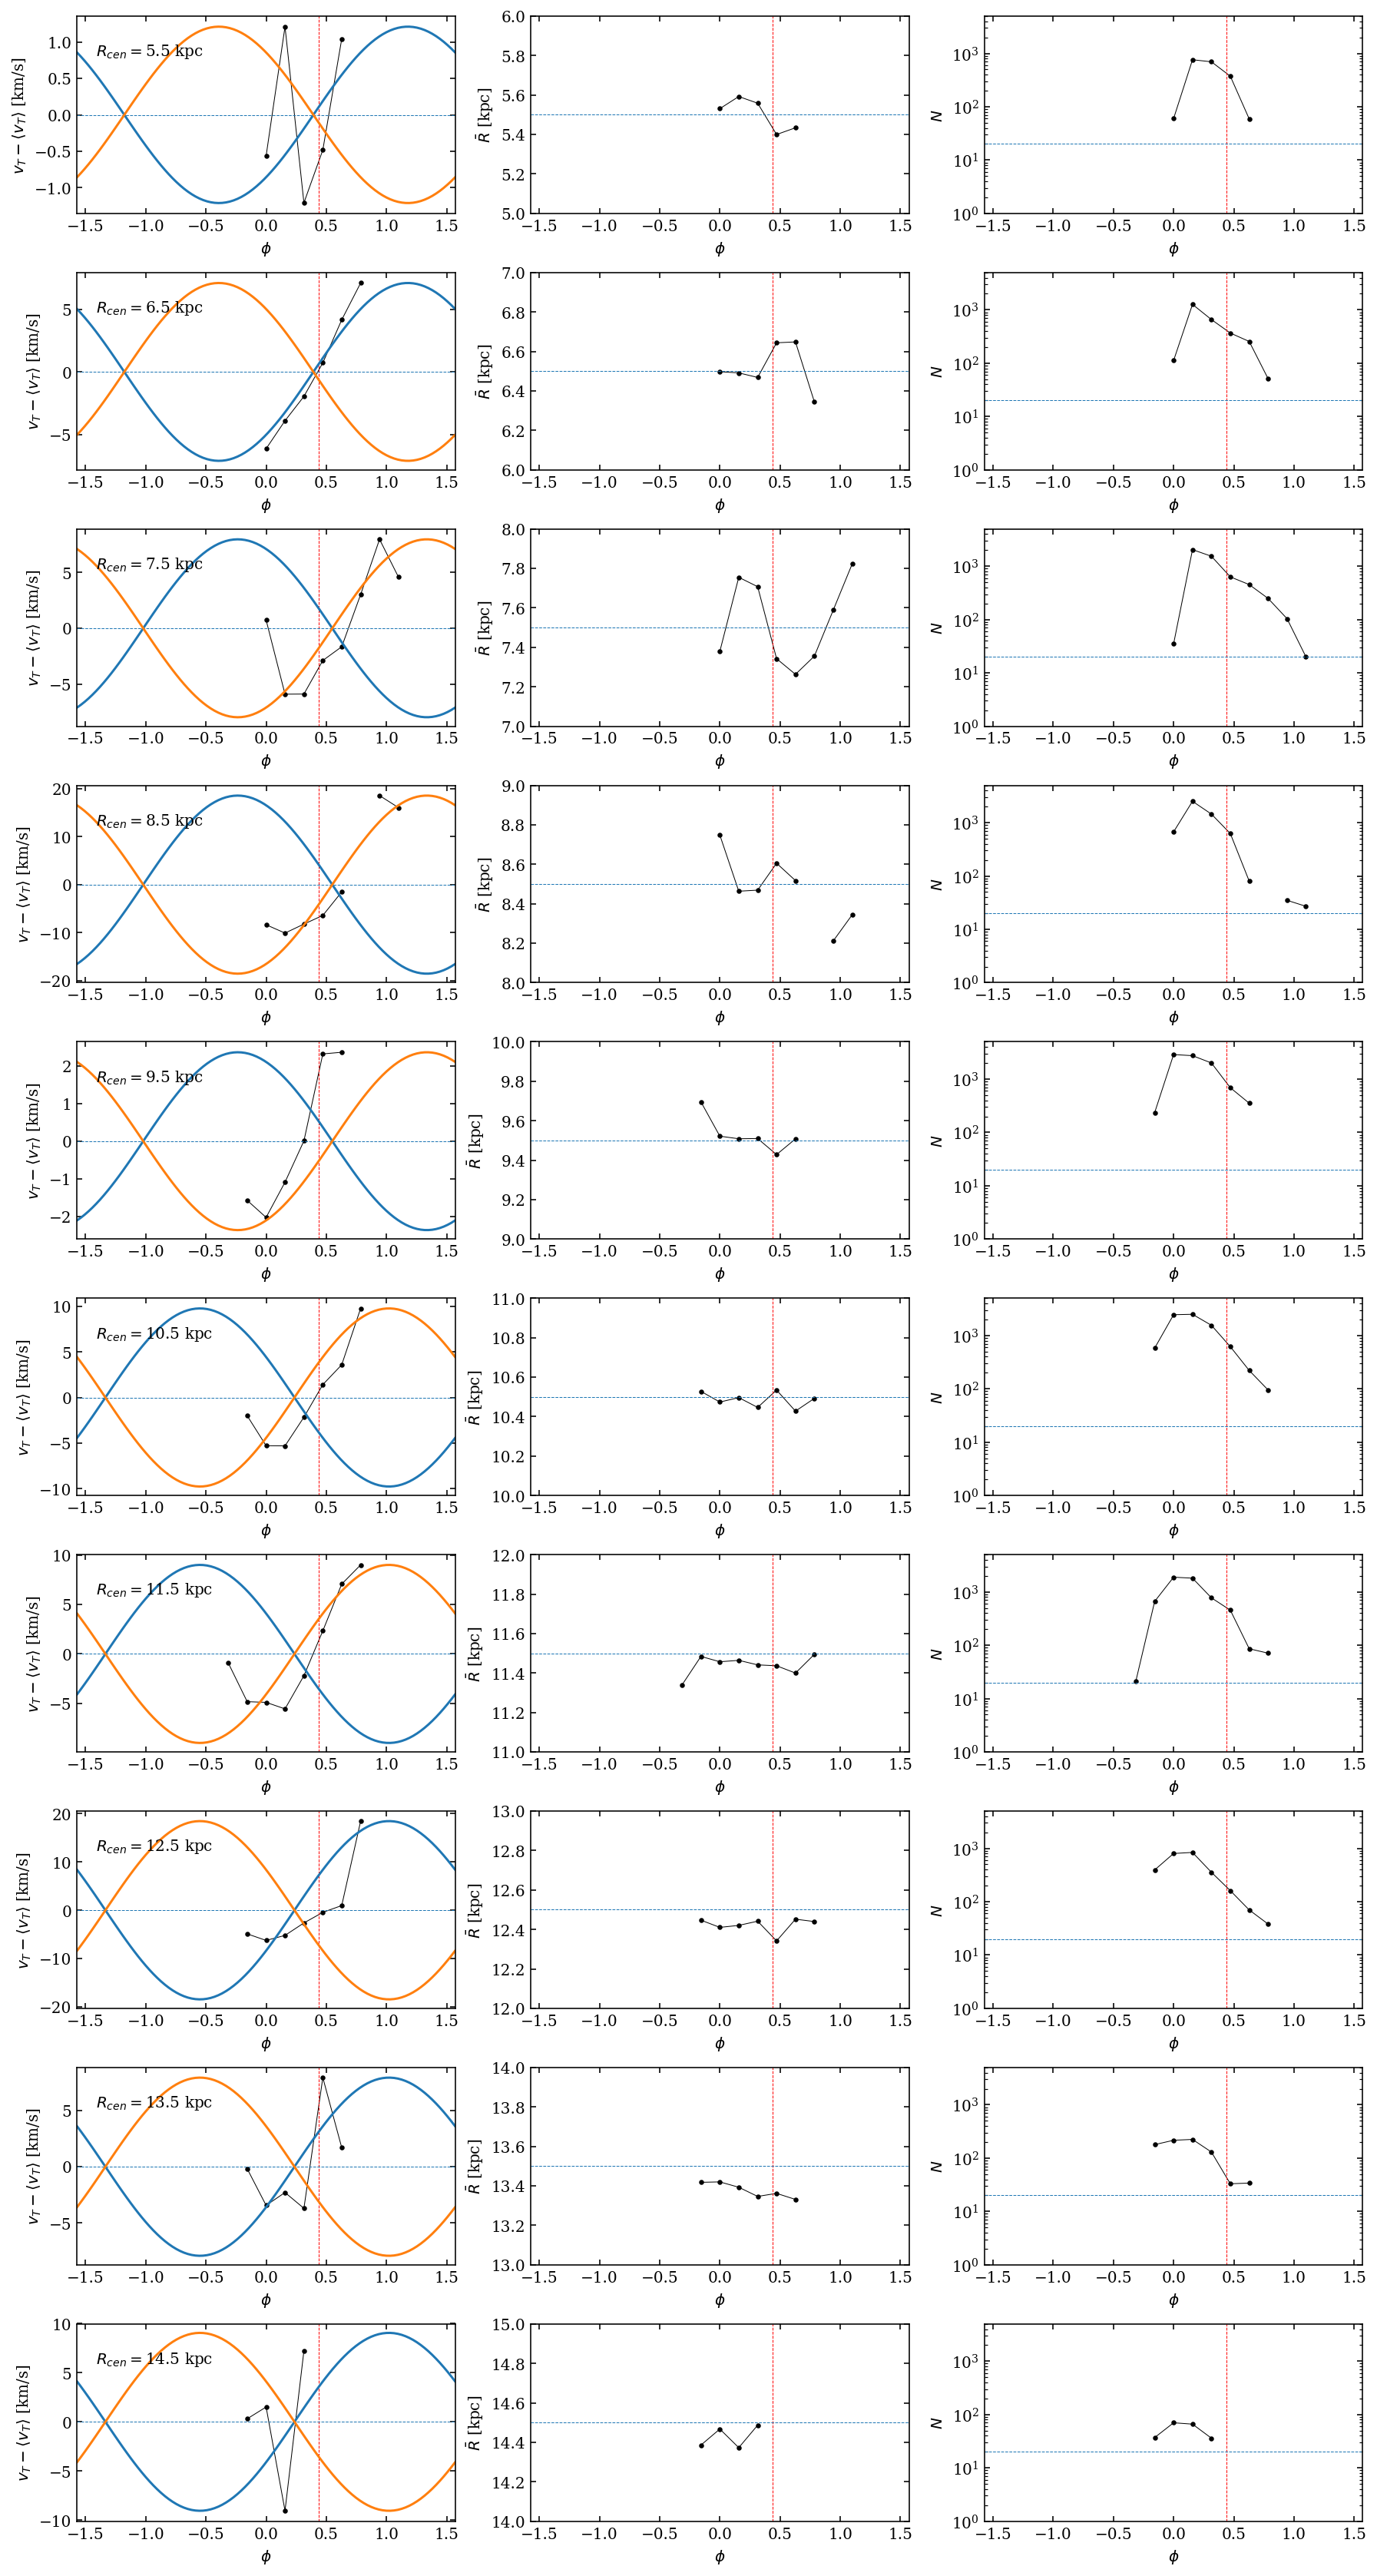

In [65]:
fig, axs = radial_velocity( R_bin_cents, R_bin_size, phi_lims, phi_bin_size, gc_R, gc_phi, gc_vT,
                            store_likelihood_vT, np.cos,
                            phi_bin_size_in_arc=False)

for i in range( len(R_bin_cents) ):
    axs[i,0].set_ylabel(r'$v_{T}- \langle v_{T} \rangle$ [km/s]')
##ax

fig.subplots_adjust( wspace=0.2, hspace=0.3 )

plt.show()

# Radial velocity

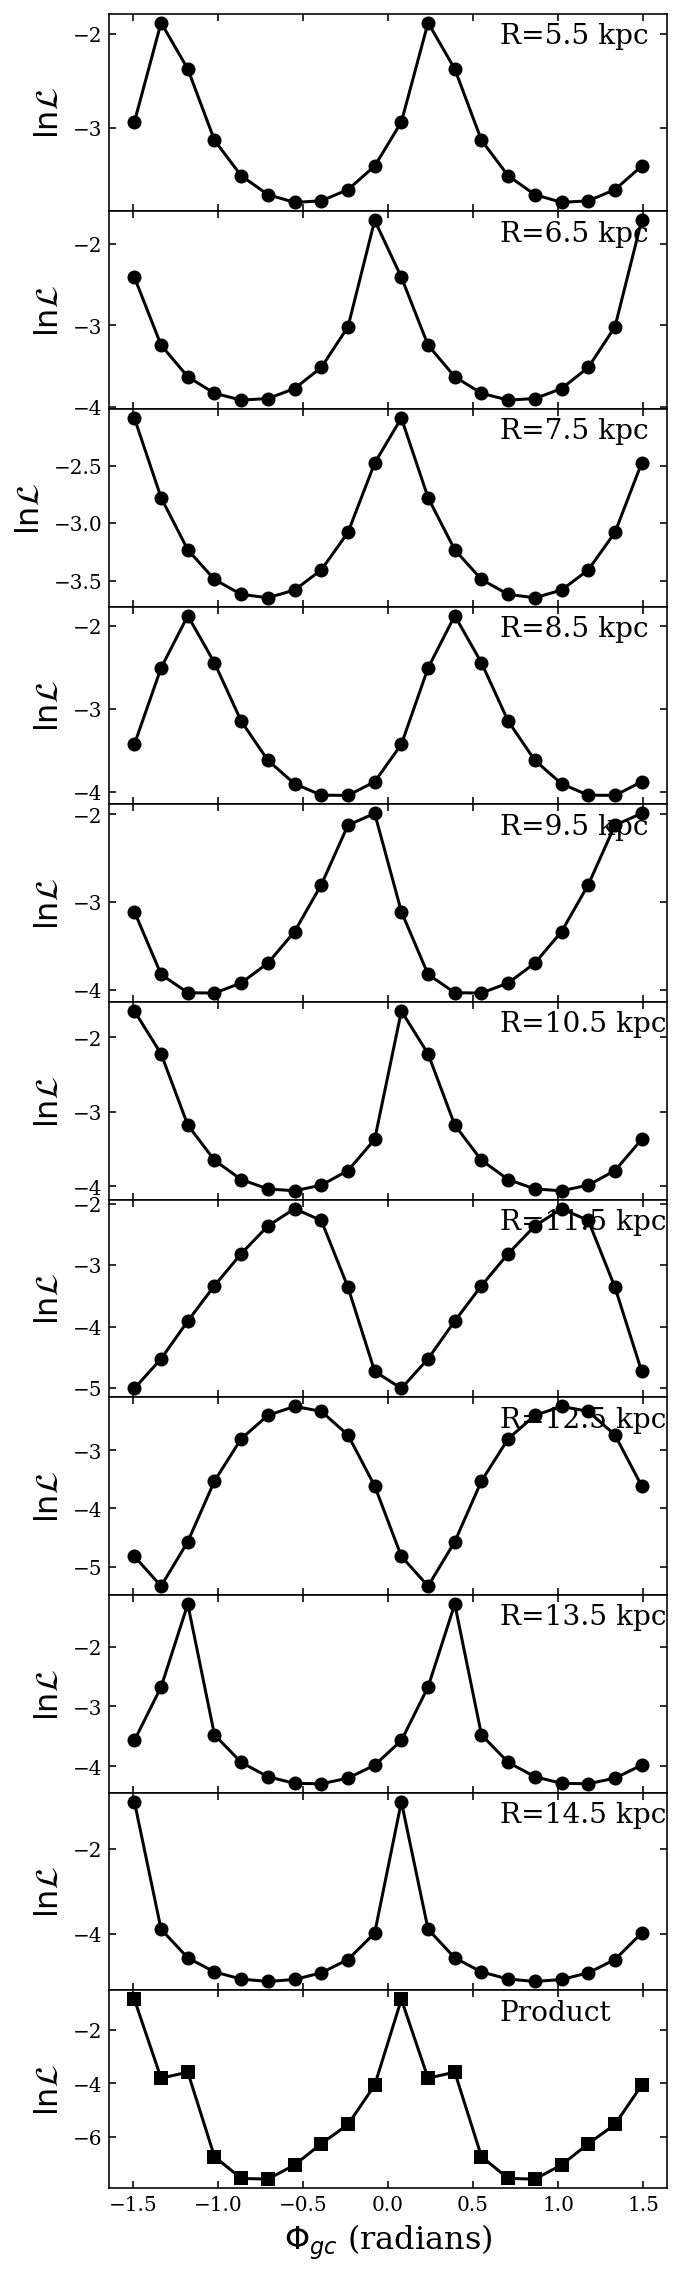

In [14]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vR = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    
    likelihood = calculate_data_likelihood(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, n_bs=50,
                                           force_yint_zero=True, trig_function=np.sin)
    store_likelihood_vR[i,:] = np.log(likelihood)
        
    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood), marker='o', color='Black' )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].tick_params(labelbottom='off')
    ##fi

prod_likelihood_vR = np.sum(store_likelihood_vR, axis=0)
prod_likelihood_vR = normalize_log_likelihood( prod_likelihood_vR )

axs[-1].plot( phib_bin_cents, prod_likelihood_vR, marker='s', color='Black' )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)     

axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;

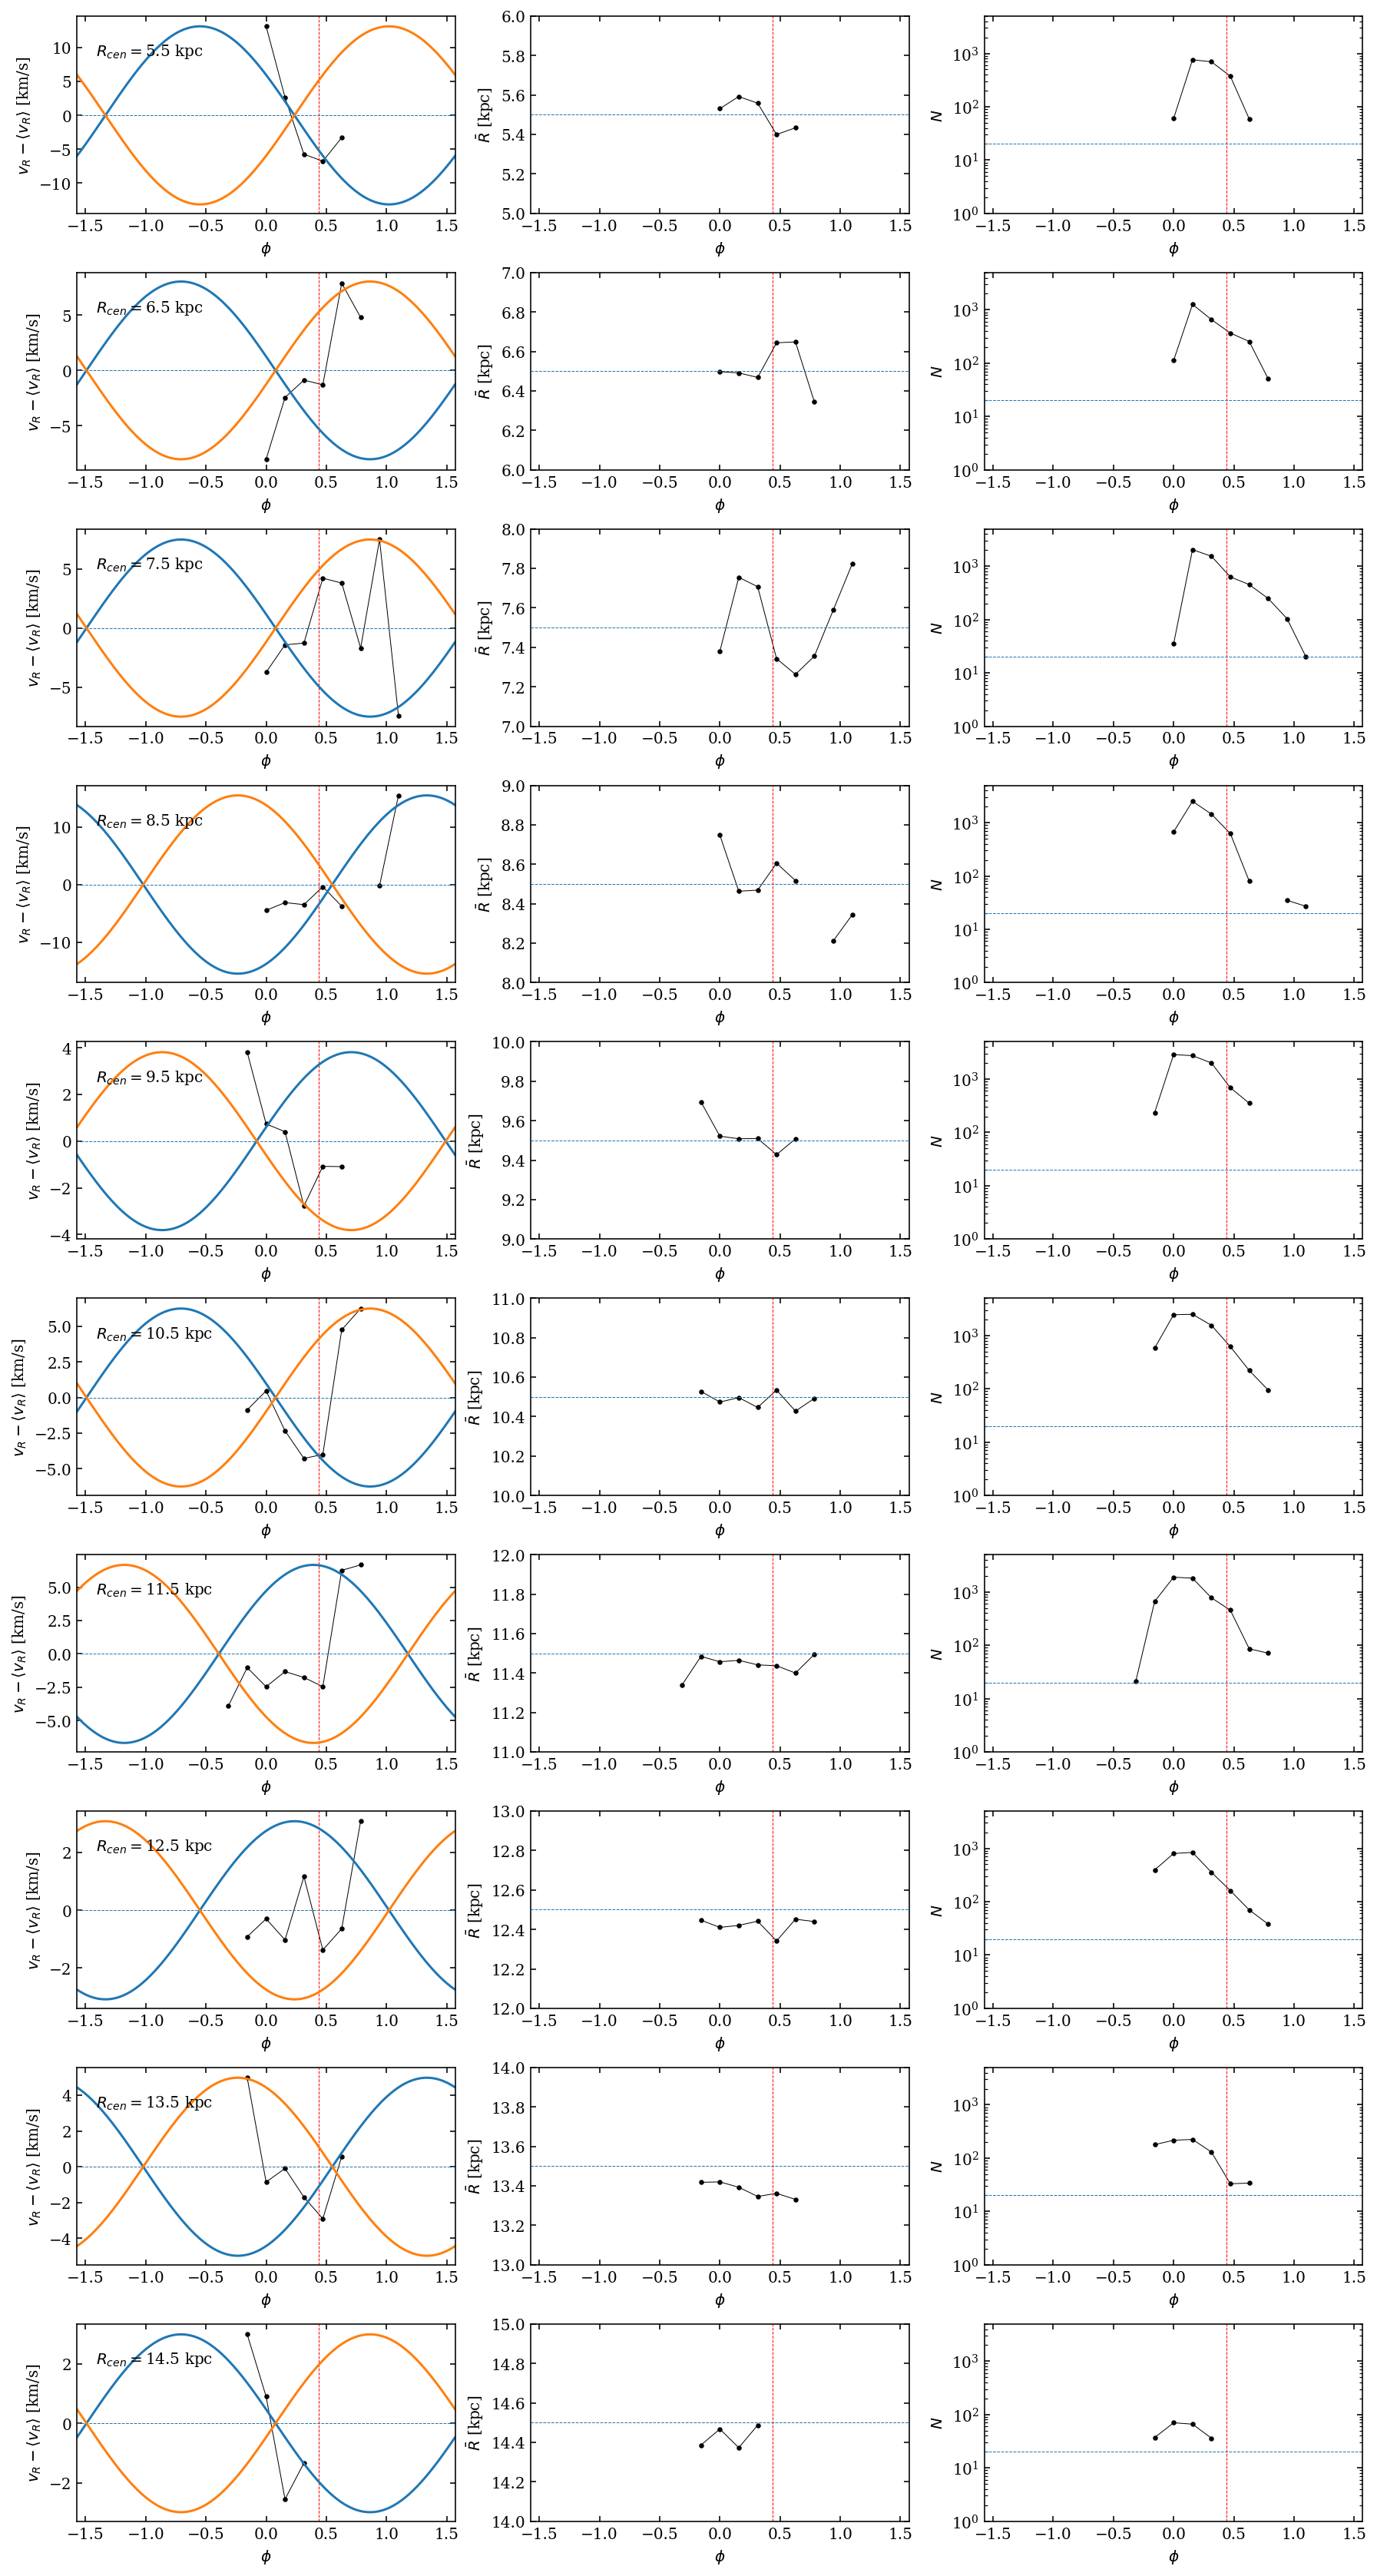

In [66]:
fig, axs = radial_velocity( R_bin_cents, R_bin_size, phi_lims, phi_bin_size, gc_R, gc_phi, gc_vR,
                            store_likelihood_vR, np.cos,
                            phi_bin_size_in_arc=False)

for i in range( len(R_bin_cents) ):
    axs[i,0].set_ylabel(r'$v_{R}- \langle v_{R} \rangle$ [km/s]')
##ax

fig.subplots_adjust( wspace=0.2, hspace=0.3 )

plt.show()

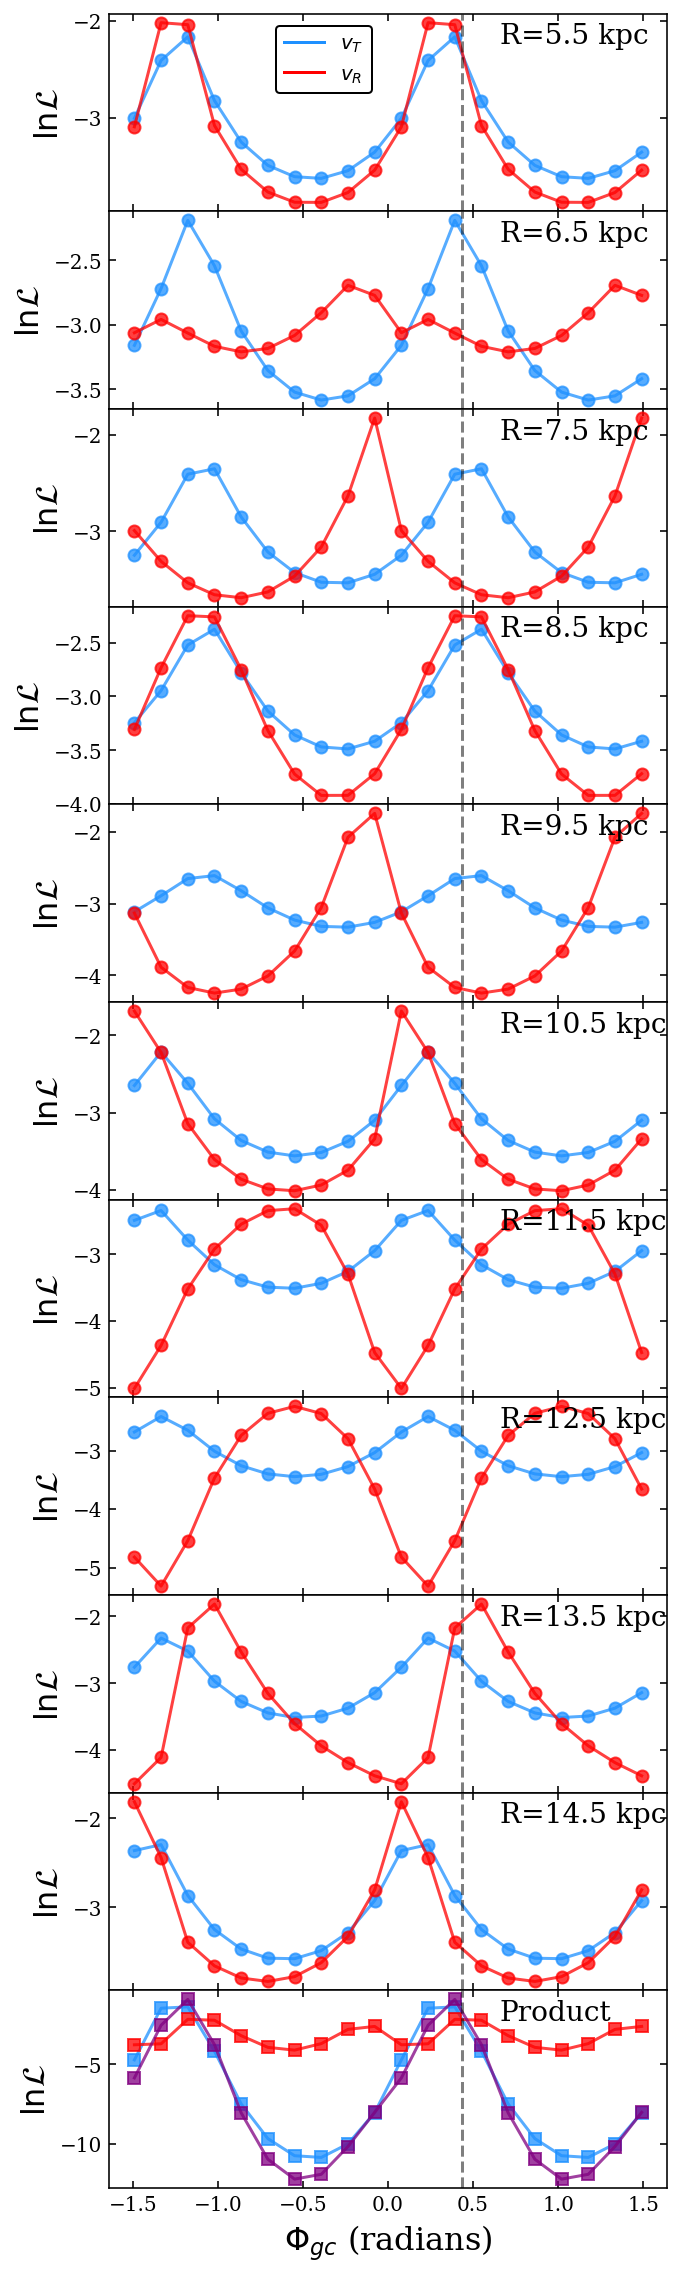

In [70]:
fig = plt.figure( figsize=(5,20) )
axs = fig.subplots( nrows=n_R_bins+1, ncols=1 )

store_likelihood_vR = np.ones( ( n_R_bins, n_phib_bins ) )
store_likelihood_vT = np.ones( ( n_R_bins, n_phib_bins ) )

for i in range(n_R_bins):
    
    likelihood_vT = calculate_data_likelihood(gc_R, gc_phi, gc_vT, R_bin_cents[i], R_bin_size, n_bs=50,
                                           force_yint_zero=False, trig_function=np.cos)
    store_likelihood_vT[i,:] = np.log(likelihood_vT)
    
    likelihood_vR = calculate_data_likelihood(gc_R, gc_phi, gc_vR, R_bin_cents[i], R_bin_size, n_bs=50,
                                           force_yint_zero=True, trig_function=np.sin)
    store_likelihood_vR[i,:] = np.log(likelihood_vR)
        
    # Plot
    axs[i].plot( phib_bin_cents, np.log(likelihood_vT), marker='o', color='DodgerBlue', alpha=0.75 )
    axs[i].plot( phib_bin_cents, np.log(likelihood_vR), marker='o', color='Red', alpha=0.75 )
    axs[i].annotate('R='+str(R_bin_cents[i])+' kpc', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
    axs[i].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
    axs[i].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )
    axs[i].tick_params(labelbottom='off')
    ##fi

axs[0].plot([], [], color='DodgerBlue', label=r'$v_{T}$')
axs[0].plot([], [], color='Red', label=r'$v_{R}$')
axs[0].legend(loc=(0.3,0.6))
    
prod_likelihood_vT = np.sum(store_likelihood_vT, axis=0)
prod_likelihood_vT = normalize_log_likelihood( prod_likelihood_vT )
prod_likelihood_vR = np.sum(store_likelihood_vR, axis=0)
prod_likelihood_vR = normalize_log_likelihood( prod_likelihood_vR )
prod_likelihood_both = prod_likelihood_vR + prod_likelihood_vT
prod_likelihood_both = normalize_log_likelihood( prod_likelihood_both )

axs[-1].plot( phib_bin_cents, prod_likelihood_vT, marker='s', color='DodgerBlue', alpha=0.75 )
axs[-1].plot( phib_bin_cents, prod_likelihood_vR, marker='s', color='Red', alpha=0.75 )
axs[-1].plot( phib_bin_cents, prod_likelihood_both, marker='s', color='Purple', alpha=0.75 )
axs[-1].annotate('Product', fontsize=14, xy=(0.7,0.85), xycoords='axes fraction')
axs[-1].set_ylabel(r'$\ln \mathcal{L}$', fontsize=16)
axs[-1].axvline( np.pi*25/180, color='Black', linestyle='dashed', alpha=0.5 )

axs[-1].set_xlabel(r'$\Phi_{gc}$ (radians)', fontsize=16)
fig.subplots_adjust(hspace=0)
plt.show()
pass;